<a href="https://colab.research.google.com/github/geniusserg/DataAnalyzis/blob/main/ConvolutionNetwork_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
import torch
import torchvision
import numpy as np
import cv2
import torchvision.datasets
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt


In [165]:
device = "cuda" if torch.cuda.is_available() else "cpu"

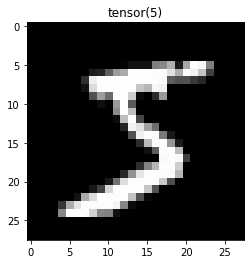

In [166]:

trainig_dataset = torchvision.datasets.MNIST(
    "/content",
    download=True,
    train = True,
    transform = ToTensor(),
    target_transform=lambda x: torch.nn.functional.one_hot(torch.tensor(x), num_classes=10).to(torch.float)
)

test_dataset = torchvision.datasets.MNIST(
    "/content",
    download=True,
    train = False,
    transform = ToTensor(),
    target_transform=lambda x: torch.nn.functional.one_hot(torch.tensor(x), num_classes=10).to(torch.float)
)

training_dataloader = DataLoader(trainig_dataset, batch_size=64)
testing_dataloader = DataLoader(test_dataset, batch_size=64)

img = next(iter(training_dataloader))
plt.imshow(img[0][0].squeeze(), cmap = "gray")
plt.title(np.argmax(img[1][0]))
plt.show()

Define DNN model

In [167]:
class DNN(torch.nn.Module):
  def __init__(self):
    super(DNN, self).__init__()
    self.flatten = torch.nn.Flatten()
    self.linear_stack = torch.nn.Sequential(
        torch.nn.Linear(28*28, 10),
        torch.nn.LogSoftmax(),
    )

  def forward(self, x):
    x_flatten = self.flatten(x)
    y_logits = self.linear_stack(x_flatten)
    return y_logits
    
model = DNN().to(device)

from torchsummary import summary
summary(model, input_size=(28*28,), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [64, 784]               0
            Linear-2                   [64, 10]           7,850
        LogSoftmax-3                   [64, 10]               0
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.39
Params size (MB): 0.03
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


Define learning and validaion processes

In [168]:
learning_rate = 1e-3
batch_size = 64
epochs = 1
optimizer = torch.optim.SGD(model.parameters(), learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

In [169]:
def test_loop(dataloader, model, loss_fn):
    dataset_len = len(dataloader.dataset)
    correct = 0
    error = 0
    with torch.no_grad():
      for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        error += loss_fn(pred, y).item()
    return error, correct/dataset_len
    
test_loop(testing_dataloader, model, torch.nn.CrossEntropyLoss())

(365.3822581768036, 0.1081)

In [173]:
def train(dataloader, model, loss_fn, optimizer, epochs):
    dataset_len = len(dataloader.dataset)
    history = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}
    t_loss = 0
    t_acc = 0
    for epoch in range(epochs):
      total_loss = 0
      total_correct = 0
      for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss
        total_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        if batch%10==0:
            print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,batch,total_correct/dataset_len,total_loss))

      err, acc = test_loop(testing_dataloader, model, loss_fn)

      history["train_loss"].append(total_loss.item())
      history["train_accuracy"].append(total_correct/dataset_len)
      history["test_loss"].append(err)
      history["test_accuracy"].append(acc)
    return history


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0, minibatch 0: train acc = 0.00013333333333333334, train loss = 2.333162784576416
Epoch 0, minibatch 10: train acc = 0.0015333333333333334, train loss = 25.408735275268555
Epoch 0, minibatch 20: train acc = 0.0028166666666666665, train loss = 48.684181213378906
Epoch 0, minibatch 30: train acc = 0.004183333333333333, train loss = 71.65808868408203
Epoch 0, minibatch 40: train acc = 0.005933333333333333, train loss = 94.50048065185547
Epoch 0, minibatch 50: train acc = 0.00775, train loss = 117.21577453613281
Epoch 0, minibatch 60: train acc = 0.009883333333333333, train loss = 139.78672790527344
Epoch 0, minibatch 70: train acc = 0.012116666666666666, train loss = 162.27682495117188
Epoch 0, minibatch 80: train acc = 0.014883333333333333, train loss = 184.5955810546875
Epoch 0, minibatch 90: train acc = 0.017783333333333335, train loss = 206.70062255859375
Epoch 0, minibatch 100: train acc = 0.020866666666666665, train loss = 228.8577880859375
Epoch 0, minibatch 110: train acc =

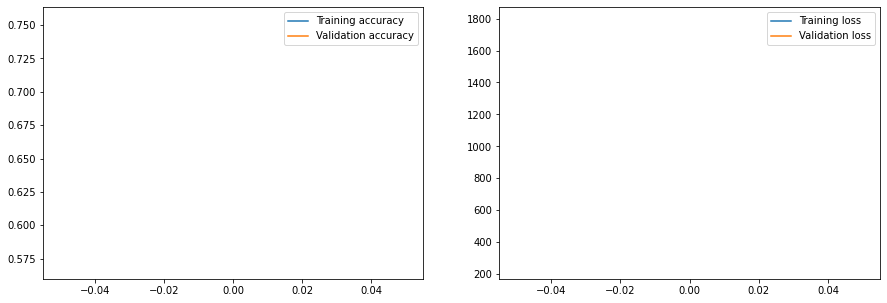

In [174]:
hist = train(training_dataloader, model, loss_fn, optimizer, epochs)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_accuracy'], label='Training accuracy')
plt.plot(hist['test_accuracy'], label='Validation accuracy')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['test_loss'], label='Validation loss')
plt.legend()

Visualize network layer on several inputs

In [175]:
image_dict = {}
c = 0
while(len(image_dict)!=10):
  img, next_num = trainig_dataset[c]
  next_num = torch.argmax(next_num).cpu().item()
  if next_num not in image_dict:
    image_dict[next_num] = img[0]
  c += 1

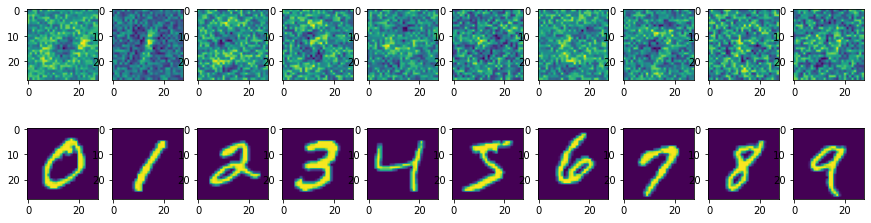

In [176]:

with torch.no_grad():
  layer_weights = next(model.parameters())
  fig, ax = plt.subplots(2,10,figsize=(15,4))
  for i in range(len(layer_weights)):
    ax[0][i].imshow(layer_weights[i].view(28, 28).cpu().detach())
    ax[1][i].imshow(image_dict[i])
plt.show()

## Two layers with RELU

In [177]:
class DNN_ReLU(torch.nn.Module):
  def __init__(self):
    super(DNN_ReLU, self).__init__()
    self.flatten = torch.nn.Flatten()
    self.linear_stack = torch.nn.Sequential(
        torch.nn.Linear(28*28, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 10),
        torch.nn.LogSoftmax(),
    )

  def forward(self, x):
    x_flatten = self.flatten(x)
    y_logits = self.linear_stack(x_flatten)
    return y_logits
    
model = DNN_ReLU().to(device)

from torchsummary import summary
summary(model, input_size=(28*28,), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [64, 784]               0
            Linear-2                  [64, 100]          78,500
              ReLU-3                  [64, 100]               0
            Linear-4                   [64, 10]           1,010
        LogSoftmax-5                   [64, 10]               0
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.49
Params size (MB): 0.30
Estimated Total Size (MB): 0.98
----------------------------------------------------------------


Train model

Epoch 0, minibatch 0: train acc = 0.00011666666666666667, train loss = 2.3040075302124023
Epoch 0, minibatch 10: train acc = 0.005083333333333333, train loss = 23.317285537719727
Epoch 0, minibatch 20: train acc = 0.011933333333333334, train loss = 40.338714599609375
Epoch 0, minibatch 30: train acc = 0.020133333333333333, train loss = 52.80519485473633
Epoch 0, minibatch 40: train acc = 0.028683333333333335, train loss = 62.25392532348633
Epoch 0, minibatch 50: train acc = 0.0372, train loss = 70.14512634277344
Epoch 0, minibatch 60: train acc = 0.04616666666666667, train loss = 76.96723937988281
Epoch 0, minibatch 70: train acc = 0.055433333333333334, train loss = 82.896240234375
Epoch 0, minibatch 80: train acc = 0.06448333333333334, train loss = 88.61529541015625
Epoch 0, minibatch 90: train acc = 0.07381666666666667, train loss = 93.27236938476562
Epoch 0, minibatch 100: train acc = 0.08333333333333333, train loss = 97.37158966064453
Epoch 0, minibatch 110: train acc = 0.092683333

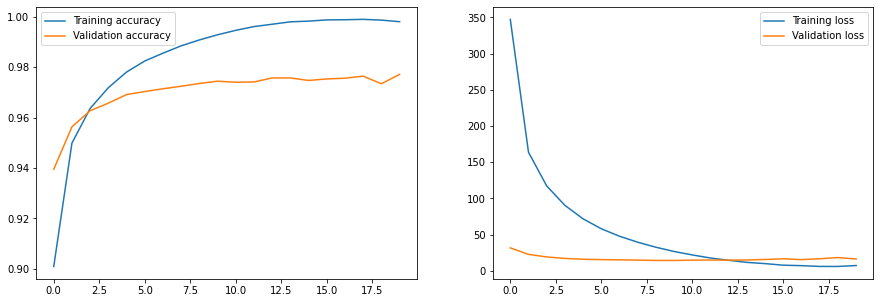

In [178]:
learning_rate = 1e-3
batch_size = 64
epochs = 1
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

hist = train(training_dataloader, model, loss_fn, optimizer, epochs)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_accuracy'], label='Training accuracy')
plt.plot(hist['test_accuracy'], label='Validation accuracy')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['test_loss'], label='Validation loss')
plt.legend()

Visualize weight of neural network

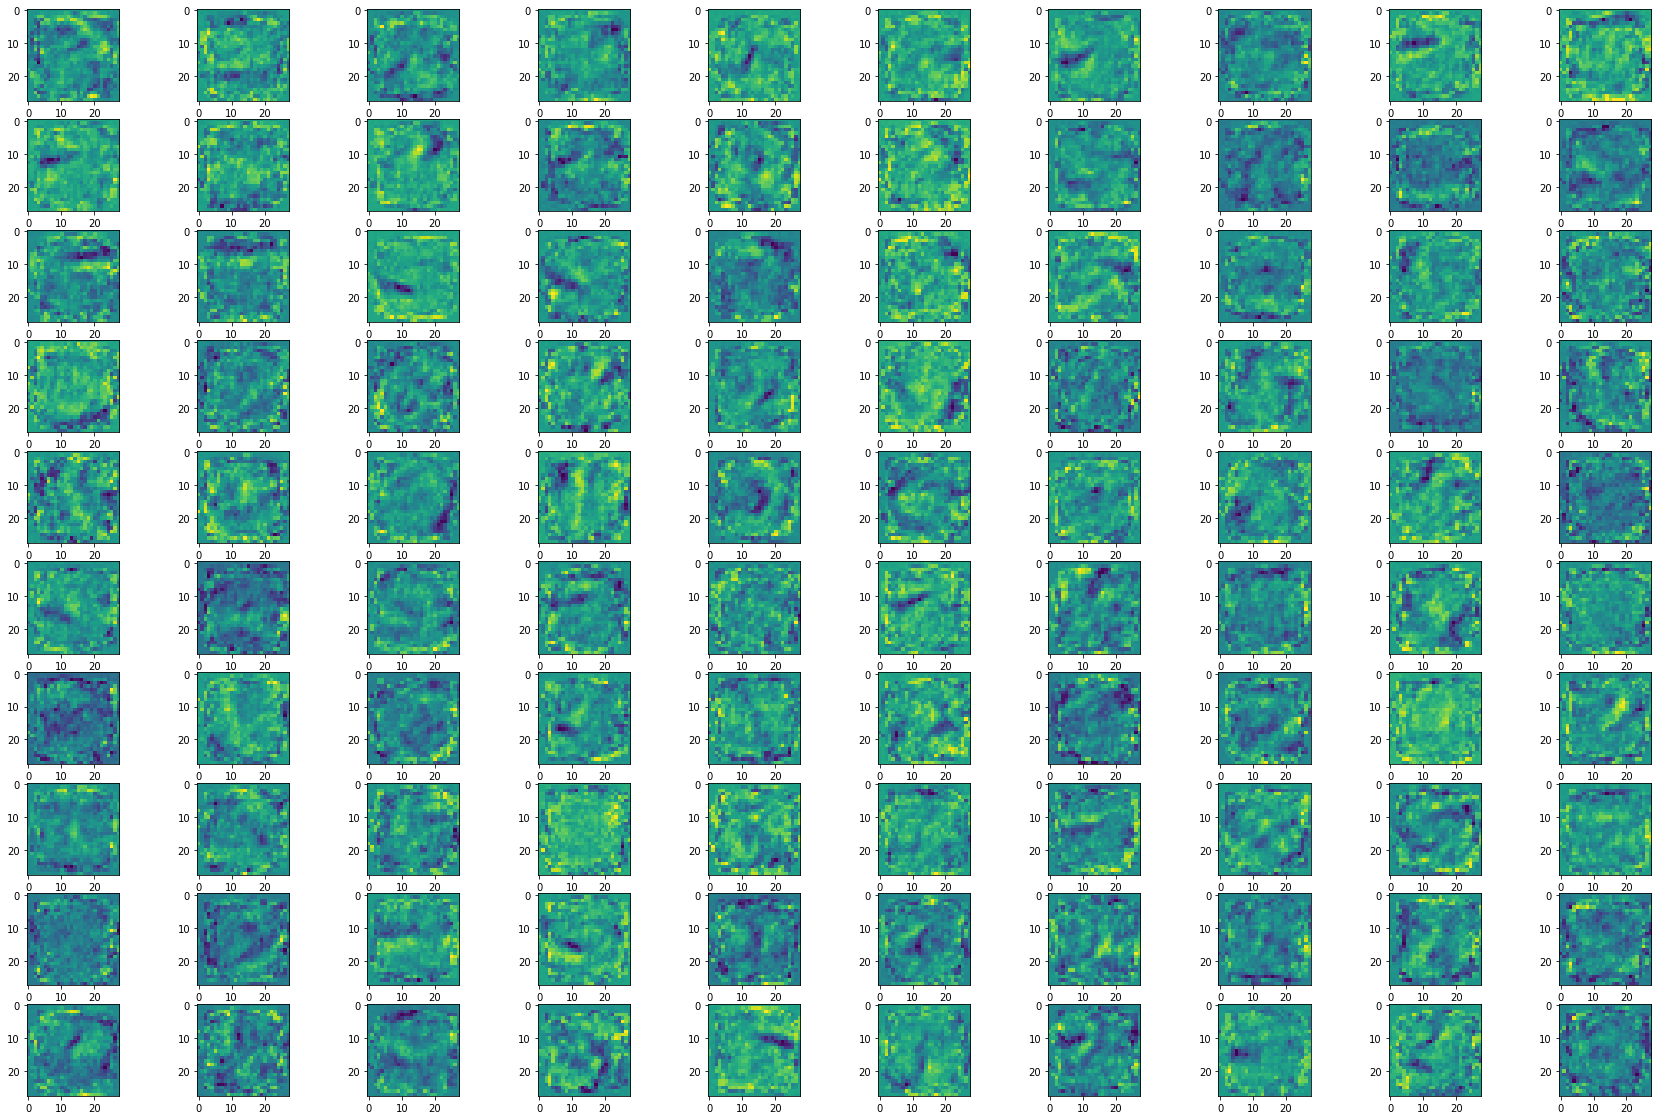

In [179]:
with torch.no_grad():
  layer_weights = next(model.parameters())
  fig, ax = plt.subplots(10,10,figsize=(30,20))
  for j in range(10):
    for i in range(10):
      ax[j][i].imshow(layer_weights[j*10+i].view(28, 28).cpu().detach())
plt.show()

## Convolutional Networks

In [180]:
class ConvNN(torch.nn.Module):
  def __init__(self):
    super(ConvNN, self).__init__()
    self.conv = torch.nn.Conv2d(
        in_channels = 1,
        out_channels = 9,
        kernel_size = (5, 5)
    )
    self.activation = torch.nn.ReLU()
    self.flatten = torch.nn.Flatten()
    self.lin = torch.nn.Linear(5184, 10)
    self.output = torch.nn.LogSoftmax()

  def forward(self, x):
    x = self.conv(x)
    x = self.activation(x)
    x = self.flatten(x)
    x = self.lin(x)
    x = self.output(x)
    return x

model = ConvNN().to(device)

<ipython-input-180-f91b27e63e3a>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)


Epoch 0, minibatch 0: train acc = 6.666666666666667e-05, train loss = 2.3025994300842285
Epoch 0, minibatch 10: train acc = 0.0047666666666666664, train loss = 22.646825790405273
Epoch 0, minibatch 20: train acc = 0.012566666666666667, train loss = 37.43326950073242
Epoch 0, minibatch 30: train acc = 0.021033333333333334, train loss = 46.70573806762695
Epoch 0, minibatch 40: train acc = 0.029883333333333335, train loss = 52.89014434814453
Epoch 0, minibatch 50: train acc = 0.03863333333333333, train loss = 58.18014907836914
Epoch 0, minibatch 60: train acc = 0.047983333333333336, train loss = 62.73659896850586
Epoch 0, minibatch 70: train acc = 0.05748333333333333, train loss = 66.8044204711914
Epoch 0, minibatch 80: train acc = 0.06696666666666666, train loss = 70.7961654663086
Epoch 0, minibatch 90: train acc = 0.0766, train loss = 73.83525848388672
Epoch 0, minibatch 100: train acc = 0.08643333333333333, train loss = 76.62017059326172
Epoch 0, minibatch 110: train acc = 0.0958333333

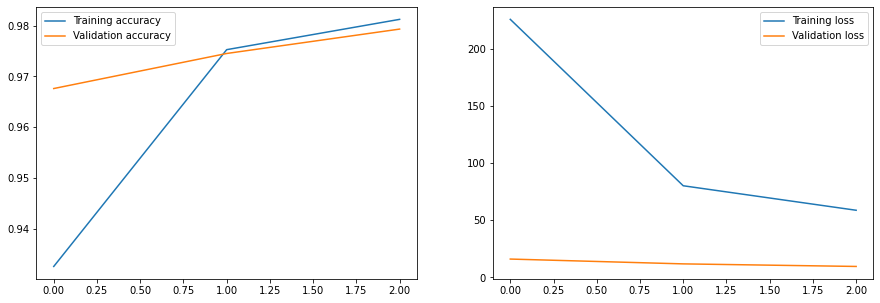

In [181]:
learning_rate = 1e-3
batch_size = 64
epochs = 3
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

hist = train(training_dataloader, model, loss_fn, optimizer, epochs)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_accuracy'], label='Training accuracy')
plt.plot(hist['test_accuracy'], label='Validation accuracy')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['test_loss'], label='Validation loss')
plt.legend()

In [ ]:
from torchsummary import summary
summary(model, input_size=(1, 28,28), batch_size=64)

In [ ]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(model.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

## Usage of Pre-Trained Model

Load Cats and Dogs

In [ ]:
import os
if not os.path.exists('data/kagglecatsanddogs_5340.zip'):
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [185]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

In [186]:
import glob
from PIL import Image

def check_image_dir(path):
    for fn in glob.glob(path):
      try:
        im = Image.open(fn)
        im.verify()
      except:
        print("Corrupt image: {}".format(fn))
        os.remove(fn)

check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

Define needed transformations

In [187]:
import torchvision.transforms as transforms
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize])
dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

In [188]:
# Download model weights in the sandbox environment
!mkdir -p ~/.torch/models
!wget -P ~/.torch/models -q https://download.pytorch.org/models/vgg16-397923af.pth

In [189]:
vgg = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
tsq = trainset[0][0].unsqueeze(dim=0)
res = vgg(tsq)
res[0].argmax()

tensor(284)

In [190]:
import json, requests
class_map = json.loads(requests.get("https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02123597', 'Siamese_cat']

## Use VGG

In [191]:
vgg.to(device)
summary(vgg, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Extract features model

In [193]:
summary(vgg.features, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Extract features from images

In [194]:
bs = 8
num = bs*100
dataloader = torch.utils.data.DataLoader(trainset, batch_size=bs)
feature_vec = torch.zeros(num, 512*7*7).to(device)
label_vec = torch.zeros(num).to(device)
i = 0
for x, l in dataloader:
  with torch.no_grad():
    f = vgg.features(x.to(device)) 
    feature_vec[i: i+bs] = f.view(bs, -1)
    label_vec[i:i+bs] = l
    i += bs
    print(".", end='')
    if i>=num:
      break


....................................................................................................

In [ ]:
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
feature_dataset = TensorDataset(feature_vec, label_vec)
vgg_train, vgg_test = random_split(feature_dataset, [700, 100])
vgg_train_dataloader = DataLoader(vgg_train, batch_size=8)
vgg_test_dataloader = DataLoader(vgg_test, batch_size=8)

Use simple Linear LAyer as classsificator Net

In [ ]:
vgg.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 2), torch.nn.LogSoftmax()).to(device)
for x in vgg.features.parameters():
    x.requires_grad = False
  
summary(vgg, (3,244,244)) 

In [197]:
def train(model, dataloader, testing_dataloader, loss_fn, optimizer, epochs):
    dataset_len = len(dataloader.dataset)
    history = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}
    for epoch in range(epochs):
      total_loss = 0
      total_correct = 0
      for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss
        _,predicted = torch.max(pred,1)
        total_correct+=(predicted==y).sum()
        if batch%10==0:
            print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,batch,total_correct/dataset_len,total_loss))

      err, acc = test_loop(testing_dataloader, model, loss_fn)

      history["train_loss"].append(total_loss.item())
      history["train_accuracy"].append(total_correct/dataset_len)
      history["test_loss"].append(err)
      history["test_accuracy"].append(acc)
    return history

In [198]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

hist = train(vgg,
             train_loader,
             test_loader,
             loss_fn=torch.nn.CrossEntropyLoss(),
             optimizer=torch.optim.Adam(vgg.parameters(), 1e-3),
             epochs=1)

Epoch 0, minibatch 0: train acc = 0.0003499999875202775, train loss = 0.8217316269874573
Epoch 0, minibatch 10: train acc = 0.007949999533593655, train loss = 2.8241822719573975
Epoch 0, minibatch 20: train acc = 0.015699999406933784, train loss = 3.3910953998565674
Epoch 0, minibatch 30: train acc = 0.023349998518824577, train loss = 6.352850437164307
Epoch 0, minibatch 40: train acc = 0.031049998477101326, train loss = 7.229405403137207
Epoch 0, minibatch 50: train acc = 0.03869999945163727, train loss = 9.416382789611816
Epoch 0, minibatch 60: train acc = 0.04645000025629997, train loss = 11.333632469177246
Epoch 0, minibatch 70: train acc = 0.054249998182058334, train loss = 12.380499839782715
Epoch 0, minibatch 80: train acc = 0.06174999848008156, train loss = 16.185422897338867
Epoch 0, minibatch 90: train acc = 0.06955000013113022, train loss = 17.69521141052246
Epoch 0, minibatch 100: train acc = 0.07724999636411667, train loss = 19.941612243652344
Epoch 0, minibatch 110: train

KeyboardInterrupt: ignored

In [ ]:
torch.save(vgg,'data/cats_dogs.pth')